# Precipitation Analysis and Models

In [1]:
import seaborn as sb
import pandas as pd
import numpy as np

### Import and Clean DataFrame
#### Import and Examine
First thing we need to do is import our data and examine our columns.

In [2]:
frame = pd.read_csv("temp_prcp_jonesboro_2016-2017_selected.csv", index_col='DATE')

cols = set(frame.columns.values)
print(cols)

{'ELEVATION', 'REPORTTPYE', 'HOURLYPrecip', 'HOURLYStationPressure', 'HOURLYDRYBULBTEMPF', 'STATION_NAME', 'LATITUDE', 'LONGITUDE', 'STATION', 'HOURLYRelativeHumidity'}


There are several columns we can drop out that will not affect our analysis.

#### Flush Columns
Next we drop our columns we don't need.

In [3]:
cols -= set(['DATE', 'LATITUDE', 'LONGITUDE', 'STATION', 'STATION_NAME', 'ELEVATION', 'REPORTTPYE'])
frame = frame.filter(cols)

#### Bad Data
We need to take a look at our DataFrame and verify all of our rows contain good values.

In [4]:
for col in cols:
    blanks = frame[pd.isna(frame[col])].shape[0]
    print("There are {} problems in {}.".format(blanks,col))

There are 0 problems in HOURLYPrecip.
There are 6 problems in HOURLYStationPressure.
There are 4 problems in HOURLYDRYBULBTEMPF.
There are 31 problems in HOURLYRelativeHumidity.


#### Fixing Data
So we are showing issues. So how do we want to handle them? Easiest way is just to throw it out, but I don't think that would be the best way to handle it. A better yet flawed method of fixing our data is to simply fill forward our data from the rows above. 

In [5]:
frame = frame.fillna(method='ffill')

for col in cols:
    blanks = frame[pd.isna(frame[col])].shape[0]
    print("There are {} problems in {}.".format(blanks,col))

There are 0 problems in HOURLYPrecip.
There are 0 problems in HOURLYStationPressure.
There are 0 problems in HOURLYDRYBULBTEMPF.
There are 0 problems in HOURLYRelativeHumidity.


#### Establish our Samples
We pull out the we days and dry days from our frame and then sample from the combined lists. We take an equal sample from both of those samples.

In [6]:
seed = 42
yCol = {'HOURLYPrecip'}
xCol = cols - yCol
# wetDays = frame[frame[list(yCol)] != 'NONE']  #This doesn't work as its not the same
wetDays = frame[frame.HOURLYPrecip != 'NONE']
dryDays = frame[frame.HOURLYPrecip != 'RAIN']
dryDays = dryDays.sample(n=wetDays.shape[0], replace=False, random_state=seed)
samples = pd.concat([dryDays,wetDays])
samplesX = samples[list(xCol)].values
# samplesY = samples[list(yCol)].values    #Again, referencing yCol doesn't work.
samplesY = samples.HOURLYPrecip.values

### Model Testing
Now we can start to do the heavy lifting. We will use the same sample for all of our testing.

#### Logistic Regression -- Baseline

In [7]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import *

from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression()
lrScores = cross_val_score(logReg, samplesX, samplesY, cv=5)
lrPred = cross_val_predict(logReg, samplesX, samplesY, cv=5)

#### Gradient Boosting

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
gradBoost = GradientBoostingClassifier()
gbScores = cross_val_score(gradBoost, samplesX, samplesY, cv=5)
gbPred = cross_val_predict(gradBoost, samplesX, samplesY, cv=5)

c:\users\steve\.virtualenvs\fun_data_sci-eylsbe5b\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Support Vector Machine

In [9]:
from sklearn.svm import SVC
suppVect = SVC()
svcScores = cross_val_score(suppVect, samplesX, samplesY, cv=5)
svcPred = cross_val_predict(suppVect, samplesX, samplesY, cv=5)

#### Analysis of Test

In [10]:
print("Logistic Regression \tAccuracy = {0:.2%}".format(accuracy_score(samplesY, lrPred)))
print("Gradient Boosting \tAccuracy = {0:.2%}".format(accuracy_score(samplesY, gbPred)))
print("SVM \t\t\tAccuracy = {0:.2%}".format(accuracy_score(samplesY, svcPred)))
print("Just Guess NONE \tAccuracy = {0:.2%}".format(sum(frame.HOURLYPrecip == 'NONE') / frame.shape[0]))

Logistic Regression 	Accuracy = 73.80%
Gradient Boosting 	Accuracy = 67.64%
SVM 			Accuracy = 65.00%
Just Guess NONE 	Accuracy = 82.94%


It appears that Logistic Regression is better than both Gradient Boosting and SVM. Quite surprising actually. Now onto setting up our actually fitting!

### Training
We want to use 20% of our data for our validation set and the rest for our training set.

#### Sample Setups

In [11]:
valSize = samples.shape[0] * 0.2

# Reset our wet and dry days.
wetDays = samples[samples.HOURLYPrecip != 'NONE']
dryDays = samples[samples.HOURLYPrecip != 'RAIN']

valWet = wetDays.sample(n=(int(valSize/2)), replace=False, random_state=seed)
valDry = dryDays.sample(n=(int(valSize/2)), replace=False, random_state=seed)
valSet = pd.concat([valWet,valDry])
valX = valSet[list(xCol)].values
valY = valSet.HOURLYPrecip.values

trainSet = samples.drop(valSet.index)
trainX = trainSet[list(xCol)].values
trainY = trainSet.HOURLYPrecip.values

#### Train

In [12]:
logReg = logReg.fit(trainX, trainY)
gradBoost = gradBoost.fit(trainX, trainY)

logRegPredProbs = logReg.predict_proba(valX)[:,1]
logRegPred = logReg.predict(valX)
gradBoostPredProbs = gradBoost.predict_proba(valX)[:,1]
gradBoostPred = gradBoost.predict(valX)

print("===== Logistic Regression =====")
print(classification_report(valY, logRegPred))
print("\n===== Gradient Boosting =====")
print(classification_report(valY, gradBoostPred))
print("\n===== Guess Rate =====")
print("'RAIN'/('RAIN' + 'NONE')  =>  {}/{} = {:.2f}".format(valWet.shape[0], valSet.shape[0], (valWet.shape[0]/valSet.shape[0])))

===== Logistic Regression =====
             precision    recall  f1-score   support

       NONE       0.77      0.65      0.71       649
       RAIN       0.70      0.81      0.75       649

avg / total       0.74      0.73      0.73      1298


===== Gradient Boosting =====
             precision    recall  f1-score   support

       NONE       0.76      0.74      0.75       649
       RAIN       0.75      0.77      0.76       649

avg / total       0.75      0.75      0.75      1298


===== Guess Rate =====
'RAIN'/('RAIN' + 'NONE')  =>  649/1298 = 0.50


It appears to be better than 50% (0.5) which is our guess rate on our balanced dataset.

#### ROC Curve on Balanced Data
http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

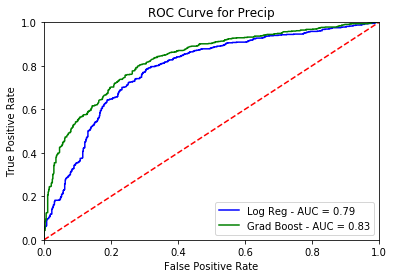

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, roc_auc_score

valNumY = (valY == "RAIN").astype(int)
fprLR, tprLR, thresholdLR = roc_curve(valNumY, logRegPredProbs)
rocAUCLR = roc_auc_score(valNumY, logRegPredProbs)
fprGB, tprGB, thresholdGB = roc_curve(valNumY, gradBoostPredProbs)
rocAUCGB = roc_auc_score(valNumY, gradBoostPredProbs)

plt.title('ROC Curve for Precip')
plt.plot(fprLR, tprLR, 'b', label = 'Log Reg - AUC = %0.2f' % rocAUCLR)
plt.plot(fprGB, tprGB, 'g', label = 'Grad Boost - AUC = %0.2f' % rocAUCGB)
plt.plot()
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

It appears Gradient Boost was a bit better than Logistic Regression. While not great we are getting some interesting data. Now let's throw it at our overall dataset using the training.

#### ROC Curve on Full Dataset

In [14]:
valX_FULL = frame[list(xCol)].values
valY_FULL = frame.HOURLYPrecip.values

logRegPredProbs_FULL = logReg.predict_proba(valX_FULL)[:,1]
logRegPred_FULL = logReg.predict(valX_FULL)
gradBoostPredProbs_FULL = gradBoost.predict_proba(valX_FULL)[:,1]
gradBoostPred_FULL = gradBoost.predict(valX_FULL)

dryDays_FULL = frame[frame.HOURLYPrecip == 'NONE']

print("===== Logistic Regression =====")
print(classification_report(valY_FULL, logRegPred_FULL))
print("\n===== Gradient Boosting =====")
print(classification_report(valY_FULL, gradBoostPred_FULL))
print("\n===== Guess Rate =====")
print("'NONE'/('RAIN' + 'NONE')  =>  {}/{} = {:.2f}".format(dryDays_FULL.shape[0], frame.shape[0], (dryDays_FULL.shape[0]/frame.shape[0])))

===== Logistic Regression =====
             precision    recall  f1-score   support

       NONE       0.95      0.68      0.79     15781
       RAIN       0.35      0.83      0.49      3246

avg / total       0.85      0.71      0.74     19027


===== Gradient Boosting =====
             precision    recall  f1-score   support

       NONE       0.95      0.76      0.84     15781
       RAIN       0.40      0.80      0.54      3246

avg / total       0.86      0.76      0.79     19027


===== Guess Rate =====
'NONE'/('RAIN' + 'NONE')  =>  15781/19027 = 0.83


It appears to be slightly worse than 83% (0.83) which is the guess rate if we always guessed 'NONE' instead of examining the data.

#### ROC Curve on Full Dataset

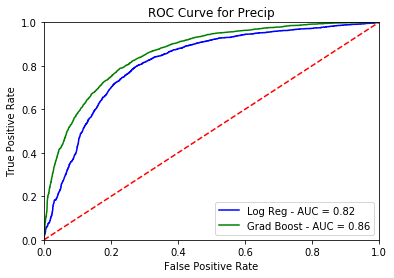

In [15]:
valNumY_FULL = (valY_FULL == "RAIN").astype(int)
fprLR_FULL, tprLR_FULL, thresholdLR_FULL = roc_curve(valNumY_FULL, logRegPredProbs_FULL)
rocAUCLR_FULL = roc_auc_score(valNumY_FULL, logRegPredProbs_FULL)
fprGB_FULL, tprGB_FULL, thresholdGB_FULL = roc_curve(valNumY_FULL, gradBoostPredProbs_FULL)
rocAUCGB_FULL = roc_auc_score(valNumY_FULL, gradBoostPredProbs_FULL)

plt.title('ROC Curve for Precip')
plt.plot(fprLR_FULL, tprLR_FULL, 'b', label = 'Log Reg - AUC = %0.2f' % rocAUCLR_FULL)
plt.plot(fprGB_FULL, tprGB_FULL, 'g', label = 'Grad Boost - AUC = %0.2f' % rocAUCGB_FULL)
plt.plot()
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Graphing and finding our AUC of the ROC curve it appears that Gradient Boosting comes out to about 0.86 which is slightly higher than the 0.83 of the guess rate.